# Day 11 - Langton's Ant

* https://adventofcode.com/2019/day/11

Today we use our Intcode computer to direct a painting robot, using rules that echo [Langton's Ant](https://en.wikipedia.org/wiki/Langton%27s_ant), a 2D cellular automaton. Celular automatons are another of AoC's recurring themes. However, this specific ant doesn't quite have the same simple rules Langton gave his ant..

I've opted for implementing the robot as a Python generator function, having the Intcode CPU's print opcode send its output to the generator using it's [`generator.send()` method](https://docs.python.org/3/reference/expressions.html#generator.send). Input is then a simple deque (add robot observations to one end, the Intcode input opcode takes values from the other).

In [1]:
from __future__ import annotations
from collections import deque
from enum import Enum
from types import TracebackType
from typing import (
    cast,
    ContextManager,
    Deque,
    Dict,
    Generator,
    List,
    Literal,
    NamedTuple,
    Optional,
    Tuple,
    Union,
    TYPE_CHECKING
)

from intcode import CPU, Instruction, InstructionSet, base_opcodes


TURN = Literal[0, 1]
COLOUR = Literal[0, 1]


class Pos(NamedTuple):
    x: int = 0
    y: int = 0
        
    def move(self, dx: int, dy: int) -> Pos:
        return self._replace(x=self.x + dx, y=self.y + dy)

        
Hullmap = Dict[Pos, COLOUR]


class Direction(Enum):
    #       dx, dy, turn l,  turn r
    up    =  0, -1, 'left',  'right'
    left  = -1,  0, 'down',  'up'
    down  =  0,  1, 'right', 'left'
    right =  1,  0, 'up',    'down'
    
    if TYPE_CHECKING:
        dx: int
        dy: int
        _turns: Tuple[str, str]
    
    def __new__(cls, dx: int, dy: int, turn_left: str, turn_right: str) -> Direction:
        self = object.__new__(cls)
        self._value_ = (dx, dy)
        self.dx, self.dy = dx, dy
        self._turns = (turn_left, turn_right)
        return self
    
    def turn(self, direction: TURN) -> Direction:
        return type(self)[self._turns[direction]]
    
    def __call__(self, pos: Pos) -> Pos:
        """Move forward one step"""
        return pos.move(self.dx, self.dy)


PaintRunner = Generator[None, Union[TURN, COLOUR], None]


class HullPaintingRobot(ContextManager[PaintRunner]):
    painted: Hullmap
    _runner: Optional[PaintRunner] = None

    def __init__(self, output: Deque[COLOUR]) -> None:
        self.painted = {}
        self._output = output
    
    def powerdown(self) -> None:
        if self._runner is not None:
            self._runner.close()
            self._runner = None
    
    def __enter__(self) -> PaintRunner:
        if self._runner is None:
            self._runner = self.run()
            # prime the runner, outputting its first observation
            # and waiting for input.
            next(self._runner)
        return self._runner
    
    def __exit__(self, *exc) -> None:
        self.powerdown()
        
    def run(self) -> Generator[None, Union[TURN, COLOUR], None]:
        pos: Pos = Pos()
        direction: Direction = Direction.up
        hull = self.painted

        while True:
            self._output.append(hull.get(pos, 0))
            self.painted[pos] = yield None
            direction = direction.turn((yield None))
            pos = direction(pos)


def testrun() -> None:
    output: Deque[COLOUR] = deque()
    robot = HullPaintingRobot(output)
    with robot as run:
        # and so any input instructions at this point should be provided 0
        assert output[0] == 0
        
        # Suppose the robot eventually outputs 1 (paint white) and then 0 (turn left)
        run.send(cast(COLOUR, 1))
        run.send(cast(TURN, 0))
        assert robot.painted == {Pos(0, 0): 1}
        # Input instructions should still be provided 0
        assert output[-1] == 0
        assert len(output) == 2

        # Next, the robot might output 0 (paint black) and then 0 (turn left):
        run.send(cast(COLOUR, 0))
        run.send(cast(TURN, 0))
        assert robot.painted == {Pos(0, 0): 1, Pos(-1, 0): 0}
        
        # After more outputs (1,0, 1,0):
        for c, t in ((1, 0), (1, 0)):
            run.send(cast(COLOUR, c))
            run.send(cast(TURN, t))
        assert robot.painted == {
            Pos(0, 0): 1,
            Pos(-1, 0): 0,
            Pos(-1, 1): 1,
            Pos(0, 1): 1,
        }
        # ... because it is now on a white panel, input instructions should be provided 1
        assert output[-1] == 1
        
        # After several more outputs (0,1, 1,0, 1,0)
        for c, t in ((0, 1), (1, 0), (1, 0)):
            run.send(cast(COLOUR, c))
            run.send(cast(TURN, t))
        assert robot.painted == {
            Pos(0, 0): 0,
            Pos(-1, 0): 0,
            Pos(-1, 1): 1,
            Pos(0, 1): 1,
            Pos(1, 0): 1,
            Pos(1, -1): 1,
        }


testrun()


def execute_robot(memory: List[int], hull: Optional[Hullmap] = None) -> Hullmap:
    outputs: Deque[COLOUR] = deque()
    robot = HullPaintingRobot(outputs)
    if hull is not None:
        robot.painted = hull
    with robot as runner:
        opcodes: InstructionSet = {
            **base_opcodes,
            3: Instruction(outputs.popleft, output=True),
            4: Instruction(runner.send, 1),
        }
        CPU(opcodes).reset(memory).execute()
    return robot.painted

In [2]:
import aocd
data = aocd.get_data(day=11, year=2019)
memory = list(map(int, data.split(',')))

In [3]:
part1_hull = execute_robot(memory)
print("Part 1:", len(part1_hull))

Part 1: 1771


## Part 2

Part 2 simply changes the first position to be white instead of black, so we simply add `Pos(0, 0): 1` to the initial mapping of our hull.

To output the result, I'm generating a PIL image.

Part 2:


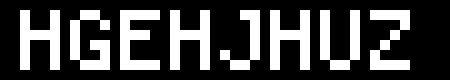

In [4]:
from PIL import Image

def show_hull(hull: Hullmap, scale: int = 10, border: bool = True) -> Image:
    minx, maxx = min(p.x for p in hull), max(p.x for p in hull)
    miny, maxy = min(p.y for p in hull), max(p.y for p in hull)
    W, H = maxx - minx + 1, maxy - miny + 1
    img = Image.new('1', (W, H), None)
    for pos, colour in hull.items():
        img.putpixel(pos.move(-minx, -miny), colour)
    if border:
        with_border = Image.new('1', (W + 2, H + 2))
        with_border.paste(img, (1, 1))
        img = with_border
    if scale != 1:
        img = img.resize((img.width * scale, img.height * scale))
    return img

part2_hull = execute_robot(memory, {Pos(0, 0): 1})
print("Part 2:")
show_hull(part2_hull)

## Animation

The painting process begs to be animated.

In [5]:
%matplotlib inline
from matplotlib import animation, rc
from matplotlib.cm import get_cmap
from matplotlib.figure import Figure
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


rc('animation', html='html5')


def animate_robot(
    memory: List[int],
    start: COLOUR = 1,
    size: int = 12,
    delay: int = 60,
) -> animation.FuncAnimation:
    frames: List[Optional[Tuple[Pos, COLOUR]]] = []

    class RecordingDict(Hullmap):
        def __setitem__(self, pos: Pos, colour: COLOUR) -> None:
            frames.append((pos, colour))
            super().__setitem__(pos, colour)

    hull = execute_robot(memory, RecordingDict({Pos(0, 0): start}))

    frames += [None] * 64  # full fade for remainder

    minx, maxx = min(p.x for p in hull), max(p.x for p in hull)
    miny, maxy = min(p.y for p in hull), max(p.y for p in hull)
    W, H = maxx - minx + 1, maxy - miny + 1

    fig, ax = plt.subplots(figsize=(size, size * (H / W)))
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1)
    ax.set_axis_off()
    
    grid = np.zeros((H + 2, W + 2), dtype=np.int8)
    image = ax.imshow(grid, vmin=0, vmax=1, cmap=get_cmap('binary').reversed())
    
    def render(move: Optional[Tuple[Pos, COLOUR]]) -> Tuple[Figure]:
        if move is not None:
            a = image.get_array()
            pos, colour = move
            a[pos.y + 1 - miny, pos.x + 1 - minx] = colour
        return image,

    anim = animation.FuncAnimation(
        fig, render, frames, interval=delay, blit=True,
        repeat_delay=1000
    )
    plt.close(fig)
    return anim


animate_robot(memory)

## Part 1 chaotic path

For completion's sake, here are the image and animation produced for part 1, which is quite ant-like in the chaotic lines it created. 

(Rendering the animation takes a while, this is mostly ffmpeg's fault, running in the background to produce the MP4).

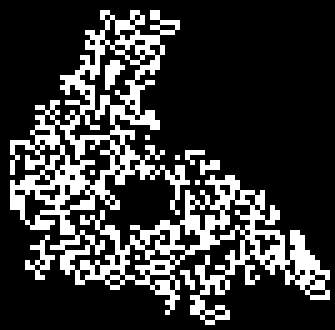

In [6]:
display(show_hull(part1_hull, scale=5))
animate_robot(memory, 0, size=5, delay=6)